In [24]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist
import skimage
import pandas as pd
import matplotlib.patches as patches
import matplotlib.image as mpimg
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import extcolors
from colormap import rgb2hex
from numpy import shape
import math
import os
from scipy.signal import medfilt
from scipy import ndimage
from numpy import ndarray
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import random
import statistics
from sklearn.cluster import KMeans


In [25]:
#Image to analyze
folder_name = 'Images_Preprocess'
file_name = 'crops5'

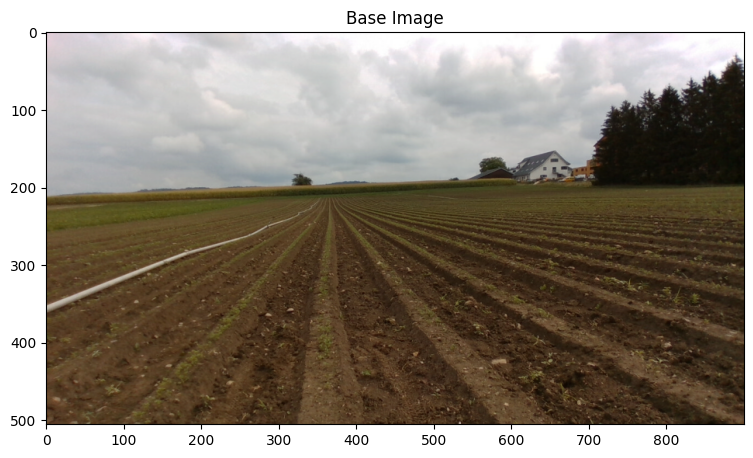

In [26]:
def read_and_normalize(folder_name, file_name) : 
    #read
    img = cv2.imread(folder_name + '/' + file_name + '.jpg')

    #resize
    output_width = 900  #set the output size
    wpercent = (output_width/float(img.shape[1]))
    hsize = int((float(img.shape[0])*float(wpercent)))
    img = cv2.resize(img, (output_width,hsize), interpolation = cv2.INTER_AREA)
    
    #display
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(9, 9))
    plt.title('Base Image')
    plt.imshow(img)

    return img

img = read_and_normalize(folder_name, file_name) # read_and_normalize(folder_name, file_name)


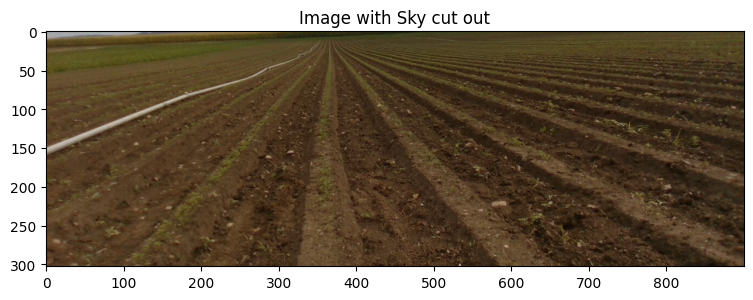

In [27]:
#REMOVE THE SKY

#Given the mask, make where the land is black
def cal_skyline(mask):
    h, w = mask.shape
    for i in range(w): #for each column
        raw = mask[:, i]
        after_median = medfilt(raw, 19)
        try:
            first_zero_index = np.where(after_median == 0)[0][0]
            first_one_index = np.where(after_median == 1)[0][0]
            if first_zero_index > 20: #if the sky is bigger then 20 px starting from the top
                mask[first_one_index:first_zero_index, i] = 1 #put 1 between sky and land
                mask[first_zero_index:, i] = 0 #put 0 in land (appears black)
                mask[:first_one_index, i] = 0 #put 0 before the sky starts 
        except:
            continue
    return mask

#Detect Sky Region (small variance between px)
def get_sky_region_gradient(img):
    h, w, _ = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.blur(img_gray, (9, 3))
    img_gray= cv2.medianBlur(img_gray, 5)
    lap = cv2.Laplacian(img_gray, cv2.CV_8U)
    gradient_mask = (lap < 6).astype(np.uint8) # we keep region with small laplacian ->sky
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
    mask = cv2.morphologyEx(gradient_mask, cv2.MORPH_ERODE, kernel) #erosion that takes the minimum of neighbouring px
    mask_sky = cal_skyline(mask)
    after_img = cv2.bitwise_and(img, img, mask=mask_sky)
    return after_img


#Cut from the top until less then 60% of sky is detected
def cut_image_from_mask(grad_sky,img):
    low = np.array([1,1,1])
    high = np.array([256,256,256])
    masked_sky = cv2.inRange(grad_sky, low, high)
    h,w = masked_sky.shape
    i = h
    count = flag = j = 0
    img_new = img
    while((i>0) & (flag==0)):
        i=i-1 
        j = count = 0
        while(j<w):
            if (masked_sky[i,j] == 255) : # if px is sky 
                count = count + 1
            j=j+1
            if (count > (w*0.3)): #cut until 30% of the line isn't sky
                lim = i; 
                flag = 1

    img_new = img[lim:,:,:]

    plt.figure(figsize=(9, 9))
    plt.title('Image with Sky cut out')
    plt.imshow(img_new)
    
    return img_new

grad_sky = get_sky_region_gradient(img)
img_no_sky = cut_image_from_mask(grad_sky, img)

In [28]:
#extract the main colors from the image 

im_pil = Image.fromarray(img)
colors_x = extcolors.extract_from_image(im_pil, tolerance = 12, limit = 12) 

def colors_to_array(colors_x) : 
    colors_rgb = np.zeros((len(colors_x[0]),3))
    colors_lab = np.zeros((len(colors_x[0]),3))

    for i in range(len(colors_x[0])):
        col = colors_x[0][i][0]
        colors_rgb[i]=col
        colors_lab[i] = color.rgb2lab((col[0]/255, col[1]/255, col[2]/255))

    return colors_rgb, colors_lab

colors_rgb, colors_lab = colors_to_array(colors_x)

In [29]:
#creat array with mask for all colors

def mask_vegetation(img_lab, col_lab):
    # Using inRange method, to create a mask
    thr = [8,8,8] #LE FAIRE EN FONCTION DE l'HISTOGRAME ??
    lower_col = col_lab - thr
    upper_col = col_lab + thr
    mask = cv2.inRange(img_lab, lower_col, upper_col)
    return mask

img_no_sky_lab = color.rgb2lab(img_no_sky/255)
arr_mask = []

for ref_color in colors_lab : 
    mask = mask_vegetation(img_no_sky_lab, ref_color)
    mask = cv2.medianBlur(mask,3)
    arr_mask.append(mask) 

No lines
max =  8 lines detected
No lines
max =  23 lines detected
max =  48 lines detected
max =  148 lines detected
No lines


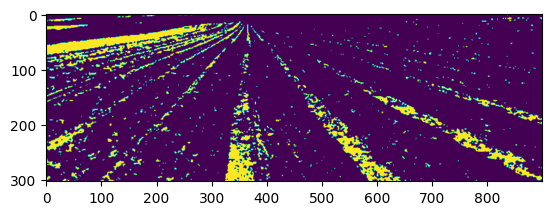

In [35]:
#Implementation of HT

def hough_line_detector(mask, img) :
    hough_thresh,hough_min_line,hough_max_gap  = [20,100,100]
    #nb pts pour qu'une ligne soit considérée
    #nb pts à la suite ds la même ligne 
    #dist entre 2 pts pour qu'ils soient reliés

    blur = cv2.medianBlur(mask,3)
    hough_image = np.matrix.copy(img)
    i = line_sing_col = 0

    # find the Hough lines using the PPHT method
    lines = cv2.HoughLinesP(image=blur, rho=1, theta=np.pi / 180, threshold=hough_thresh, 
                    minLineLength=hough_min_line, maxLineGap=hough_max_gap)

    if lines is not None:
        line_sing_col = np.zeros((len(lines),4))
        for x in range(0, len(lines)):
            for x1, y1, x2, y2 in lines[x]:
                if (math.atan2(abs(x1-x2),abs(y1-y2)) < (np.pi/2.5)) : 
                    i=i+1
                    line_sing_col[i,:] = lines[x]
                    hough_image = cv2.line(hough_image, (x1, y1), (x2, y2), (0, 0, 255), 1)

        line_sing_col = line_sing_col[:i,:]
    else:
        print("No lines")

    return i, hough_image, line_sing_col

#Loop HT around mask of different colors
max_detected = max_detected_new = 0
hough_img = 0
all_lines = []
for mask in arr_mask : 
    max_detected_new, hough_img_new, line_sing_col_new = hough_line_detector(mask, img_no_sky)
    if (max_detected_new > max_detected) : 
        max_detected = max_detected_new
        final_mask = mask
        hough_img = hough_img_new
        line_sing_col = line_sing_col_new
        print('max = ', max_detected , 'lines detected') 
        
plt.imshow(final_mask)

In [31]:
#Detect points with the most intersection = VANISHING POINT

if len(line_sing_col)>50 : 
    line_sing_col = random.choices(line_sing_col, k=30) #if too many lines, use of a random subset

def findIntersection(x1,y1,x2,y2,x3,y3,x4,y4):
    px = ( float(x1*y2-y1*x2)*float(x3-x4)-float(x1-x2)*float(x3*y4-y3*x4) ) / ( float(x1-x2)*float(y3-y4)-float(y1-y2)*float(x3-x4) ) 
    py = ( float(x1*y2-y1*x2)*float(y3-y4)-float(y1-y2)*float(x3*y4-y3*x4) ) / ( float(x1-x2)*float(y3-y4)-float(y1-y2)*float(x3-x4) )
    return [px, py]

#create array with all intersections
def createInterMaskLines(lines_h): 
    inter = []
    lines_h = np.array(lines_h)
    if lines_h is not None:
        for x in range(0, len(lines_h)):
            x1,y1,x2,y2 = lines_h[x]
            for y in range(0, x): 
                x3,y3,x4,y4 = lines_h[y]
                if (((float(x1-x2)*float(y3-y4))!=(float(y1-y2)*float(x3-x4))) & (x!=y)) : #if not // ->pour x1=x2=x3=x4=0?
                    [px, py] = findIntersection(x1,y1,x2,y2,x3,y3,x4,y4)
                    if ((px < shape(hough_img)[1]) & (px>0) & (py < shape(hough_img)[0]) & (py>0)):
                        #print(px,py)
                        inter.append([px,py]) #[x,y]=[px,py] #triangle matrix
                        if (x==0):
                            print(px,py)
                            print('o')
        inter = np.array(inter)
    return inter


inter_single = createInterMaskLines(line_sing_col)
inter_all = createInterMaskLines(np.array(all_lines)[:,0])

#inter_single = createInterArraySingleMaskLines(line_sing_col)
#inter_all = createInterArrayAllLines(all_lines)

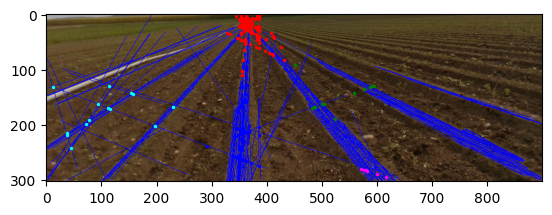

In [32]:
#K mean to cluster different intersection points

X = inter_single
kmeans = KMeans(n_clusters=5, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_kmeans = kmeans.fit_predict(X)
plt.imshow(hough_img)
plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=2, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=2, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=2, c='green', label ='Cluster 3')
plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=2, c='cyan', label ='Cluster 4')
plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], s=2, c='magenta', label ='Cluster 5')

[362, 25] [363, 69] [383, 44] [464, 95]


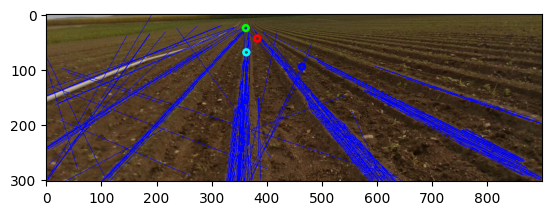

In [33]:
# Median and mean of intersections points 

p1 = [int(statistics.median(inter_single[:,0])), int(statistics.median(inter_single[:,1]))]
p2 = [int(statistics.mean(inter_single[:,0])), int(statistics.mean(inter_single[:,1]))]
p3 = [int(statistics.median(inter_all[:,0])), int(statistics.median(inter_all[:,1]))]
p4 = [int(statistics.mean(inter_all[:,0])), int(statistics.mean(inter_all[:,1]))]

print(p1,p2,p3,p4)

img_linandpoint = np.matrix.copy(hough_img)
cv2.circle(img_linandpoint, p1, 5, (0,255,0), 3) #green
cv2.circle(img_linandpoint, p2, 5, (0,255,255), 3) #cyan
cv2.circle(img_linandpoint, p3, 5, (255,0,0), 3) #red
cv2.circle(img_linandpoint, p4, 5, (0,0,255), 3) #blue

plt.imshow(img_linandpoint)

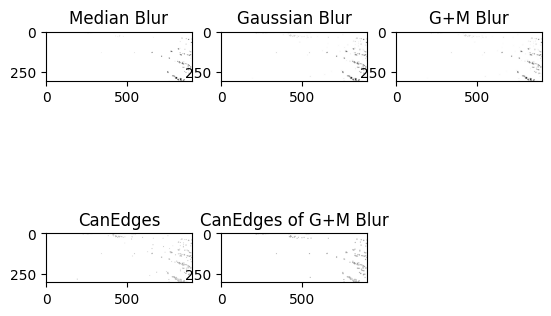

In [34]:
#DifferentImage processing, may be usefull

# dilation
kernel = np.ones((1, 1), np.uint8)
binaryMask = cv2.dilate(mask, kernel, iterations=1)

#Median Blur ->seems to be the best
blur = cv2.medianBlur(binaryMask,3)
plt.subplot(2,3,1)
plt.title("Median Blur")
plt.imshow(cv2.cvtColor(255-blur, cv2.COLOR_BGR2RGB))
#im_pil = Image.fromarray(255-blur)
#im_pil.show()

#Gaussian Blur :
blur = cv2.GaussianBlur(binaryMask, (5, 5), 0)
plt.subplot(2,3,2)
plt.title("Gaussian Blur")
plt.imshow(cv2.cvtColor(255-blur, cv2.COLOR_BGR2RGB))

#Gauss + Median Blur
blur = cv2.GaussianBlur(binaryMask, (5, 5), 0)
blur = cv2.medianBlur(blur,3)
plt.subplot(2,3,3)
plt.title("G+M Blur")
plt.imshow(cv2.cvtColor(255-blur, cv2.COLOR_BGR2RGB))
#im_pil = Image.fromarray(255-blur)
#im_pil.show()

#Canny Edge detector of Original Mask
edges = cv2.Canny(binaryMask,0,255)   #Image, min and max values
plt.subplot(2,3,4)
plt.title("CanEdges")
plt.imshow(cv2.cvtColor(255-edges, cv2.COLOR_BGR2RGB))

#Canny Edge detector of Gaussian + Median Blur
edges = cv2.Canny(blur,0,255)   #Image, min and max values
plt.subplot(2,3,5)
plt.title("CanEdges of G+M Blur")
plt.imshow(cv2.cvtColor(255-edges, cv2.COLOR_BGR2RGB))

     c_code occurence
0   #563E24    210505
1   #C8C8C8    110706
2   #392616     41139
3   #FFFFFF     34376
4   #100E08     24927
5   #5D5228     14524
6   #A3A9AC      7072
7   #765D43      3909
8   #4E4E53      2787
9   #918878      1327
10  #6D6C71      1235


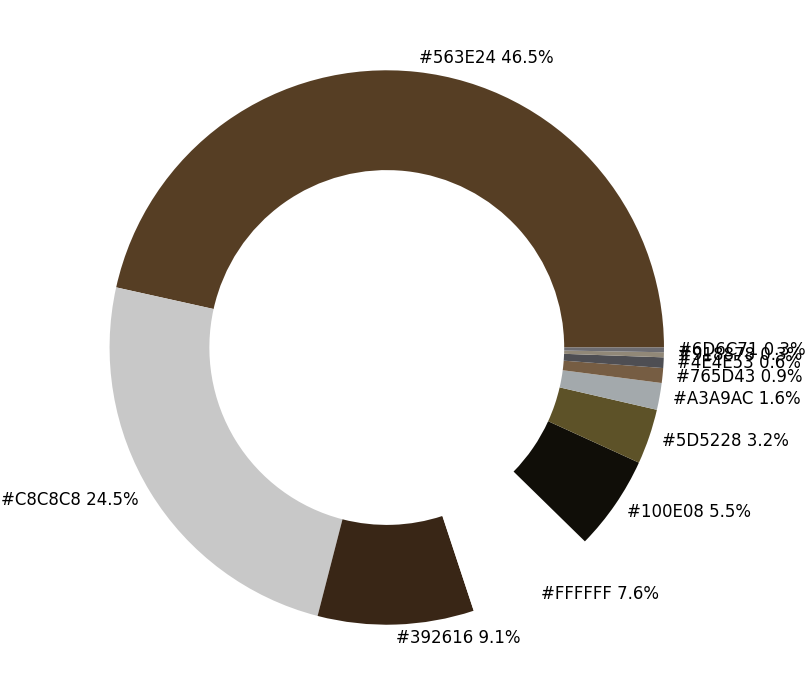

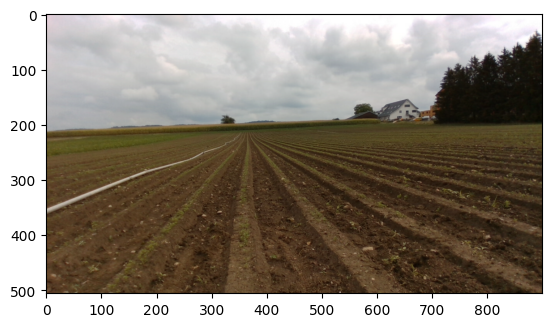

In [23]:
#Donut for debugging

def color_to_df(input):
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    return df



def donuts(colors) : 
    df_color = color_to_df(colors_x)
    print(df_color)
    list_color = list(df_color['c_code'])
    #print(list_color)
    list_precent = [int(i) for i in list(df_color['occurence'])]
    #print(list_precent)
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color, list_precent)]
    #print(text_c)
    fig, ax = plt.subplots(figsize=(90,90),dpi=10)
    wedges, text = ax.pie(list_precent,
                        labels= text_c,
                        labeldistance= 1.05,
                        colors = list_color,
                        textprops={'fontsize': 120, 'color':'black'}
                        )
    #plt.setp(wedges, width=0.3)
    #create space in the center
    plt.setp(wedges, width=0.36)
    ax.set_aspect("equal")
    fig.set_facecolor('white')
    plt.show()
    return df_color

donuts(colors_x)
plt.imshow(im_pil)